# Proyecto Telco Grupo 4:
## integrantes: Dario, Federico, Mauro, Qiyin

## Tabla de contenidos
1. [Introducción](#id1)
2. [Limpieza de datos](#id2)
    1. [Renombramos las variables para su mejor entendimiento](#ed1)
    2. [Preprocesamos los datos para los algoritmos que vamos a utilizar](#ed2)
3. [Visión general de los datos](#id3)
    1. [Variable objetivo](#ed3)
    2. [Graficos KDE para las tres variables numéricas](#ed4)
    3. [Matriz de correlaciones](#ed5)
4. [Estadistica descriptiva de las variables](#id4)
5. [Distribución de las variables en el abandono de los clientes](#id5)
    1. [Desgaste de clientes por variables categoricas](#ed6)
    2. [Desgaste de clientes por variables](#ed7)
    3. [Gastos mensuales y gastos totales por continuidad en el servicio](#ed8)
6. [Modelos de Machine Learning](#id6)
    1. [Entrenamiento de varios modelos](#ed9)
    2. [Evaluación de metricas del algoritmo de mejor performance](#ed10)
7. [Entrenando una red neuronal fully - connected](#id7)
    1. [Técnica de sobremuestreo de minorías sintéticas](#ed11)
    2. [Herramienta GridSearchCV ](#ed12)
    3. [Contrucción del modelo](#ed13)
    4. [Resultados](#ed14)

<a id="id1"></a>
# Introducción

Este conjunto de datos de IBM tiene información sobre los clientes de Telco y si abandonaron la empresa en el último mes (abandono). Cada fila representa un cliente único, mientras que las columnas contienen información sobre los servicios del cliente, la cuenta y los datos demográficos.

###### Importamos librerias y hacemos unas visualizaciones generales para ver como esta compuesto el dataset 

In [412]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.subplots as tls
import plotly.graph_objs as go

In [353]:
df = pd.read_csv("Churn.csv")

Damos un vistazo rapido a los datos

In [354]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [355]:
df.shape

(7043, 21)

<a id="id2"></a>
## Limpieza de datos

<a id="ed1"></a>
### Renombramos las variables para su mejor entendimiento

In [356]:
df.rename(columns = {'customerID':'ClienteID'}, inplace = True)
df.rename(columns = {'gender':'Genero'}, inplace = True)
df.rename(columns = {'SeniorCitizen':'MayorDeEdad'}, inplace = True)
df.rename(columns = {'Partner':'Asociado'}, inplace = True)
df.rename(columns = {'tenure':'Permanencia'}, inplace = True)
df.rename(columns = {'PhoneService':'ServicioTelefónico'}, inplace = True)
df.rename(columns = {'MultipleLines':'MultiplesLineas'}, inplace = True)
df.rename(columns = {'InternetService':'ServiciosInternet'}, inplace = True)
df.rename(columns = {'OnlineSecurity':'SeguridadOnline'}, inplace = True)
df.rename(columns = {'OnlineBackup':'BackupEnLinea'}, inplace = True)
df.rename(columns = {'DeviceProtection':'ProtecciónDispositivos'}, inplace = True)
df.rename(columns = {'TechSupport':'SoporteTecnico'}, inplace = True)
df.rename(columns = {'Contract':'Contrato'}, inplace = True)
df.rename(columns = {'PaperlessBilling':'FacturaciónEnPapel'}, inplace = True)
df.rename(columns = {'PaymentMethod':'MetodoPago'}, inplace = True)
df.rename(columns = {'MonthlyCharges':'CargoMensual'}, inplace = True)
df.rename(columns = {'TotalCharges':'CargoTotal'}, inplace = True)
df.rename(columns = {'Churn':'Abandono'}, inplace = True)

<a id="ed2"></a>
### Preprocesamos los datos para los algoritmos que vamos a utilizar

In [357]:
Id_col     = ['ClienteID']
target_col = ["Abandono"]

In [358]:
#Eliminamos el ID del cliente
df = df.drop(["ClienteID"], axis=1)

# Modificamos la variable CargoTotal a numerica y quitamos los valores nulos
df['CargoTotal'] = pd.to_numeric(df['CargoTotal'], errors='coerce')
df['CargoTotal'] = df['CargoTotal'].fillna(np.mean(df['CargoTotal']))

In [359]:
X = df.drop(["Abandono"], axis=1)
y= df['Abandono']
y= pd.get_dummies(y,drop_first=True)

#Reemplazo "No internet service" por NO en las siguientes columnas
replace_cols = [ 'SeguridadOnline', 'BackupEnLinea', 'ProtecciónDispositivos',
                'SoporteTecnico','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})


col = ['Genero', 'MayorDeEdad','Asociado','Dependents','ServicioTelefónico','MultiplesLineas','ServiciosInternet',
            'SeguridadOnline','BackupEnLinea','ProtecciónDispositivos', 'SoporteTecnico','StreamingTV','StreamingMovies',
            'Contrato','FacturaciónEnPapel','MetodoPago']

#Pasamos a numericas las variables categoricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X = X.apply(lambda col: le.fit_transform(col))
X.head(5)

,Genero,MayorDeEdad,Asociado,Dependents,Permanencia,ServicioTelefónico,MultiplesLineas,ServiciosInternet,SeguridadOnline,BackupEnLinea,ProtecciónDispositivos,SoporteTecnico,StreamingTV,StreamingMovies,Contrato,FacturaciónEnPapel,MetodoPago,CargoMensual,CargoTotal
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,142,74
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,498,3624
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,436,536
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,266,3570
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,729,674


In [360]:
#remplazo valores de Genero
df["Genero"] = df["Genero"].replace({"Male":"Masculino","Female":"Femenino"})

#Permanencia en variable categoricas
def permanecia(df) :
    
    if df["Permanencia"] <= 12 :
        return "Permanencia_0-12"
    elif (df["Permanencia"] > 12) & (df["Permanencia"] <= 24 ):
        return "Permanencia_12-24"
    elif (df["Permanencia"] > 24) & (df["Permanencia"] <= 48) :
        return "Permanencia_24-48"
    elif (df["Permanencia"] > 48) & (df["Permanencia"] <= 60) :
        return "Permanencia_48-60"
    elif df["Permanencia"] > 60 :
        return "Permanencia_60"
df["PermanenciaGrupos"] = df.apply(lambda df:permanecia(df),
                                      axis = 1)
#CargoMensual como variable categorica
def CargoMensual(df) :
    
    if df["CargoMensual"] < 20 :
        return "CargoMensual_0-20"
    elif (df["CargoMensual"] >= 20) & (df["CargoMensual"] <= 40 ):
        return "CargoMensual_20-40"
    elif (df["CargoMensual"] > 40) & (df["CargoMensual"] <= 60) :
        return "CargoMensual_40-60"
    elif (df["CargoMensual"] > 60) & (df["CargoMensual"] <= 80) :
        return "CargoMensual_60-80"
    elif df["CargoMensual"] > 80 :
        return "CargoMensual_gt_80"
df["CargoMensualGrupos"] = df.apply(lambda df:CargoMensual(df),
                                      axis = 1)

#TotalCharges como variable categorica
def CargoTotal(df) :
    
    if df["CargoTotal"] < 2000 :
        return "CargoTotal_0-2000"
    elif (df["CargoTotal"] >= 2000) & (df["CargoTotal"] <= 4000 ):
        return "CargoTotal_2000-4000"
    elif (df["CargoTotal"] > 4000) & (df["CargoTotal"] <= 6000) :
        return "CargoTotal_4000-6000"
    elif (df["CargoTotal"] > 6000) & (df["CargoTotal"] <= 8000) :
        return "CargoTotal_6000-8000"
    elif df["CargoTotal"] > 8000 :
        return "CargoTotal_8000"
df["CargoTotalGrupos"] = df.apply(lambda df:CargoTotal(df), axis = 1)

#Separar clientes que abandonaron y no abandonaron
abandonaron = df[df["Abandono"]=="Yes"]
no_abandonaron = df[df["Abandono"]=="No"]

<a id="id3"></a>
## Visión general de los datos

<a id="ed3"></a>
### Variable objetivo

In [361]:
df['Abandono'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Abandono, dtype: float64

Vamos a tratar de predecir si el cliente abandono la empresa. Por lo tanto, tenemos un problema de clasificación binaria con un dataset objetivo desequillibrado:

   * No abandono: 73.42%    
   * Abandono: 26.57%


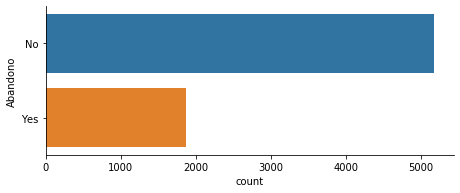

In [362]:
objetivo = sns.catplot(y="Abandono", kind="count", data=df, height=2.6, aspect=2.5, orient='h')

In [363]:
#Etiquetas
lab = df["Abandono"].value_counts().keys().tolist()
#Valores
val = df["Abandono"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'darkolivegreen','firebrick'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

Se puede observar claramente en ambas graficas el desbalanceo del dataset

<a id="ed4"></a>
### Graficos KDE para las tres variables numéricas

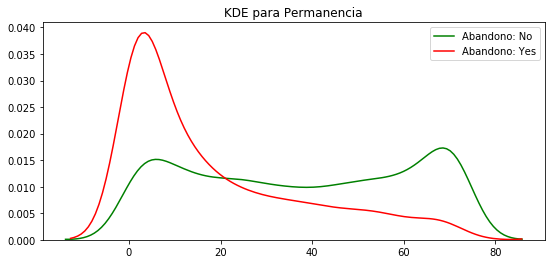

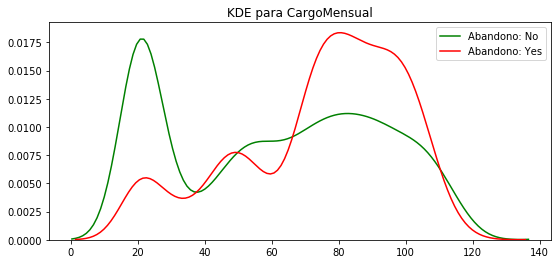

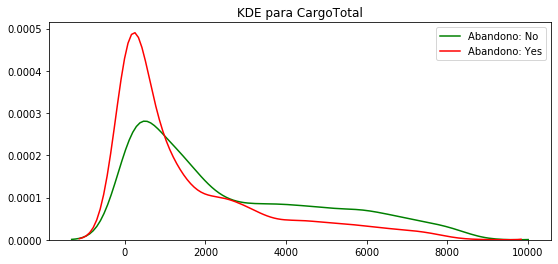

In [364]:
def kdeplot(caracteristicas):
    plt.figure(figsize=(9, 4))
    plt.title("KDE para {}".format(caracteristicas))
    ax0 = sns.kdeplot(df[df['Abandono'] == 'No'][caracteristicas].dropna(), color= 'green', label= 'Abandono: No')
    ax1 = sns.kdeplot(df[df['Abandono'] == 'Yes'][caracteristicas].dropna(), color= 'red', label= 'Abandono: Yes')
kdeplot('Permanencia')
kdeplot('CargoMensual')
kdeplot('CargoTotal')

De los graficos anteriores se destaca que:

* Los clientes recientes tienen más probabilidades de dejar la compañia.
* Los clientes con gastos mensuales más altos también tienen más probabilidades de dejar la compañia.

<a id="ed5"></a>
### Matriz de correlaciones

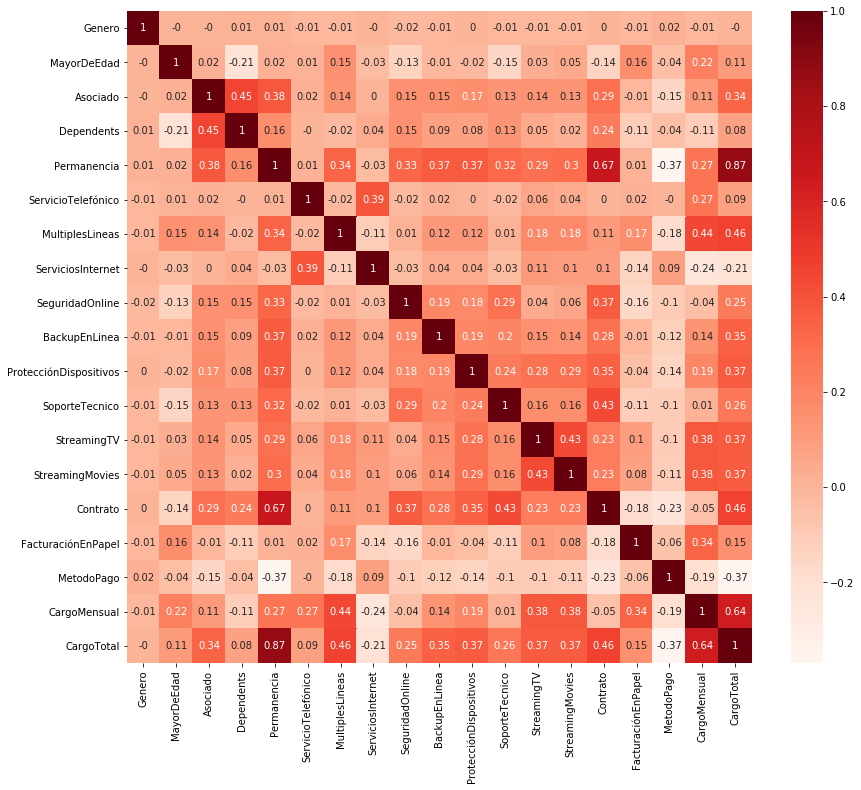

In [366]:
plt.figure(figsize=(14,12))
cor = round(X.corr(), 2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

Podemos ver en la matriz de correlación que no hay un grado de correlación significativo en las variables, solo el caso de los montos tanto totales como mensuales que estan altamente correlacionados con los meses de permanencia.

<a id="id4"></a>
## Estadistica descriptiva de las variables

In [367]:
df.describe()

,MayorDeEdad,Permanencia,CargoMensual,CargoTotal
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


<a id="id5"></a>
## Distribución de las variables en el abandono de los clientes

<a id="ed6"></a>
### Desgaste de clientes por variables categoricas

In [545]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = abandonaron[column].value_counts().values.tolist(),
                    labels  = abandonaron[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Clientes que abandonaron",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = no_abandonaron[column].value_counts().values.tolist(),
                    labels  = no_abandonaron[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Clientes que no abandonaron" 
                   )


    layout = go.Layout(dict(title = " distribución de abandono de los clientes en " + column,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "Abandonaron el servicio",
                                                font = dict(size = 11),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "No abandonaron el servicio",
                                                font = dict(size = 11),
                                                showarrow = False,
                                                x = .85,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


plot_pie("PermanenciaGrupos")
plot_pie("CargoMensualGrupos")
plot_pie("CargoTotalGrupos")

Podemos observar que:
* El 55.5% de los clientes que abandonaron el servicio son clientes que no cumplen 1 año.
* En los gastos mensuales se puede ver que mas del 70% de los clientes tiene un abono mayor a 60, sin embargo entre los      clientes que mas abandonaron servicio (mayor al 50%) el cargo es el mismo.
* El total de cargos de los que abandonaron el servicio se concentra en en los que gastan menos de 2000.

In [369]:
#Desgaste en el servicio por grupos de permanencia

tg_ch  =  abandonaron["PermanenciaGrupos"].value_counts().reset_index()
tg_ch.columns  = ["PermanenciaGrupos","count"]
tg_nch =  no_abandonaron["PermanenciaGrupos"].value_counts().reset_index()
tg_nch.columns = ["PermanenciaGrupos","count"]

trace1 = go.Bar(x = tg_ch["PermanenciaGrupos"]  , y = tg_ch["count"],
                name = "Abandonaron el servicio",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

trace2 = go.Bar(x = tg_nch["PermanenciaGrupos"] , y = tg_nch["count"],
                name = "No abandonaron el servicio",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Abandonaron el servicio en grupo de permanencia",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

#Desgaste en el servicio por grupos de gastos mensuales

tg_ch  =  abandonaron["CargoMensualGrupos"].value_counts().reset_index()
tg_ch.columns  = ["CargoMensualGrupos","count"]
tg_nch =  no_abandonaron["CargoMensualGrupos"].value_counts().reset_index()
tg_nch.columns = ["CargoMensualGrupos","count"]

trace1 = go.Bar(x = tg_ch["CargoMensualGrupos"]  , y = tg_ch["count"],
                name = "Abandonaron el servicio",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

trace2 = go.Bar(x = tg_nch["CargoMensualGrupos"] , y = tg_nch["count"],
                name = "No abandonaron el servicio",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Abandonaron el servicio en CargoMensualGrupos",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

#Desgaste en el servicio por grupos de gastos totales

tg_ch  =  abandonaron["CargoTotalGrupos"].value_counts().reset_index()
tg_ch.columns  = ["CargoTotalGrupos","count"]
tg_nch =  no_abandonaron["CargoTotalGrupos"].value_counts().reset_index()
tg_nch.columns = ["CargoTotalGrupos","count"]

trace1 = go.Bar(x = tg_ch["CargoTotalGrupos"]  , y = tg_ch["count"],
                name = "Abandonaron el servicio",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

trace2 = go.Bar(x = tg_nch["CargoTotalGrupos"] , y = tg_nch["count"],
                name = "No abandonaron el servicio",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Abandonaron el servicio en CargoTotalGrupos",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)



El desgaste del servicio por permanencia los que abandonaron el servicio no llegan al año. Tambien se observa que a medida que aumenta el gasto mensual hay un mayor numero de clientes que abandonan el servicio, y lo mismo ocurre con los gastos totales.

<a id="ed7"></a>
### Desgaste de clientes por variables

In [370]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = abandonaron[column].value_counts().values.tolist(),
                    labels  = abandonaron[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Clientes que abandonaron",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = no_abandonaron[column].value_counts().values.tolist(),
                    labels  = no_abandonaron[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Clientes que no abandonaron" 
                   )


    layout = go.Layout(dict(title = " distribution de abandono de los clientes en " + column,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "Abandonaron el servicio",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "No abandonaron el servicio",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


plot_pie("Genero")
plot_pie("MayorDeEdad")
plot_pie("ServiciosInternet")

En el grafico de genero se puede observar una igualdad en cuanto a la permanecia o no en el servicio. Podemos ver que existe una mayor proporcion de clientes que no abandonaron el servicio en los individuos que son mayores de edad, asi como tambien que la proporción de aquellos que permanecen en el mismo cuentas con tecnologia de fibra optica.

<a id="ed8"></a>
### Gastos mensuales y gastos totales por continuidad en el servicio

In [371]:
df[['CargoMensualGrupos', 'CargoTotalGrupos',"PermanenciaGrupos"]]

#scatter plot monthly charges & total charges by churn group
def plot_churncharges_scatter(abandonaron,color) :
    tracer = go.Scatter(x = df[df["Abandono"] == abandonaron]["CargoMensual"],
                        y = df[df["Abandono"] == abandonaron]["CargoTotal"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Abandono - " + abandonaron,
                        opacity = .9
                       )
    return tracer

trace6 = plot_churncharges_scatter("Yes","red")
trace7 = plot_churncharges_scatter("No","blue")

data2   = [trace7,trace6]

#layout
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Gastos mensuales",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Gastos Totales",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout


layout2  = layout_title("Gastos mensuales y gastos totales por continuidad en el servicio")

fig2 = go.Figure(data = data2,layout = layout2)

py.iplot(fig2)

Podemos observar que a mayor gasto sea total o mensual la cantidad de clientes que abandonan el servicio se dispera. No obstante la cantidad aumenta a medida que las variables mencionadas se incrementan.

<a id="id6"></a>
## Modelos de Machine Learning

###### Importamos librerias:

In [405]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble, model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *
from yellowbrick.classifier import DiscriminationThreshold

In [372]:
#Convertimos en arrays
X1 = X.values
y = y.values

In [373]:
#Normalizamos las variables
sc = StandardScaler()
X1= sc.fit_transform(X1)

In [374]:
#Generamos los set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size = 0.2,random_state = 1) #para que siempre de el mismo entrenamiento

<a id="ed9"></a>
### Entrenamiento de varios modelos

In [375]:
%%time
gboost =ensemble.GradientBoostingClassifier()
gboost.fit(X_train, y_train)
svc_cl = SVC(kernel = 'rbf', random_state = 1)
svc_cl.fit(X_train, y_train)
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
random_forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
random_forest.fit(X_train, y_train)
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
print("LISTO")

LISTO
Wall time: 1.94 s


In [376]:
%%time
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_gbbost = cross_val_score(estimator = gboost, X = X_train, y = y_train, cv = kfold,scoring=scoring)
acc_gbbost.mean()
acc_dec1 = cross_val_score(estimator = decision_tree, X = X_train, y = y_train, cv = kfold,scoring=scoring)
acc_dec1.mean()
acc_gaussion1 = cross_val_score(estimator = gaussian, X = X_train, y = y_train, cv = kfold,scoring=scoring)
acc_gaussion1.mean()
acc_knn1 = cross_val_score(estimator = knn, X = X_train, y = y_train, cv = kfold,scoring=scoring)
acc_knn1.mean()
acc_random1 = cross_val_score(estimator = random_forest, X = X_train, y = y_train, cv = kfold,scoring=scoring)
acc_random1.mean()
acc_sgd1 = cross_val_score(estimator = sgd, X = X_train, y = y_train, cv = kfold,scoring=scoring)
acc_sgd1.mean()
acc_svc1 = cross_val_score(estimator = svc_cl, X = X_train, y = y_train, cv = kfold,scoring=scoring)
acc_svc1.mean()

Wall time: 17.5 s


0.792333686053689

In [377]:
models_cross = pd.DataFrame({
    'Model': ['XG Boost','Support Vector Machines','Stochastic Gradient Decent',
              'Random Forest','Decision Tree', 'Guassian Naive Bayes', 'Kneighbours'],
    'Score': [acc_gbbost.mean(),acc_svc1.mean(),acc_sgd1.mean(),
              acc_random1.mean(),acc_dec1.mean(), acc_gaussion1.mean(), acc_knn1.mean()]})
    
models_cross.sort_values(by='Score', ascending=False)

,Model,Score
0,XG Boost,0.795530
1,Support Vector Machines,0.792334
2,Stochastic Gradient Decent,0.778845
3,Random Forest,0.776182
5,Guassian Naive Bayes,0.751859
6,Kneighbours,0.746890
4,Decision Tree,0.723465


<a id="ed10"></a>
### Evaluación de metricas del algoritmo de mejor performance

In [456]:
def metricas_xgboost(algorithm,training_x,testing_x,training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Reporte de Clasificación : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area bajo la curva : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["No abandono","Abandono"],
                        y = ["No abandono","Abandono"],
                        showscale  = False,colorscale = "RdBu",
                        name = "matriz")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "RdBu",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Matriz de confusión',
                                            'Curva ROC',
                                            'Relevancia de las caracteristicas'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Performance del modelo" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "Ratio de falsos positivos"))
    fig["layout"]["yaxis2"].update(dict(title = "Ratio de verdaderos positivos"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

 Reporte de Clasificación : 
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      1061
           1       0.63      0.57      0.60       348

    accuracy                           0.81      1409
   macro avg       0.74      0.73      0.74      1409


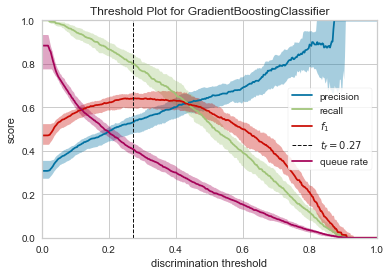

In [457]:
xgb = gboost.fit(X_train, y_train)
metricas_xgboost(xgb,X_train, X_test, y_train, y_test,
                         cols,"features",threshold_plot = True)

Podemos ver que el modelo clasifica mucho mejor a los que no abandonaron la compañia con una precisión del 86% para para esta categoria en comparación con un 63% de la otra clase. El recall es mucho peor, ya que la cantidad de falsos negativos es mayor. Esto se debe a que nuestro dataset esta desbalanceado. Por eso, a pesar de tener una presición del 80% el modelo no es del todo optimo.

<a id="id7"></a>
## Entrenando una red neuronal fully - connected

###### Importamos librerias:

In [ ]:
import tensorflow as tf
from imblearn.over_sampling import SMOTENC
#from tensorflow import keras
import os
import tempfile
from keras.layers import Dropout
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import adam
from keras.optimizers import SGD
import keras.metrics
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

<a id="ed11"></a>
### Técnica de sobremuestreo de minorías sintéticas 

La clasificación en dataset desequilibrados implica el desarrollo de modelos predictivos en conjuntos de datos de clasificación que tienen un desequilibrio de clase grave. Para ello vamos a utlizar una Técnica de sobremuestreo de minorías sintéticas (SMOTE), que consiste en:
* Elige aleatoriamente un punto de la clase minoritaria.
* Calcule los k vecinos más cercanos para este punto.
* Agregue k puntos nuevos en algún lugar entre el punto elegido y cada uno de sus vecinos.

In [496]:
cat_cols = [0]+[i for i in range(3,19)]
sm = SMOTENC(categorical_features=cat_cols, sampling_strategy='minority', random_state=42)
X_smote, y_smote = sm.fit_resample(X1, y)

In [497]:
X_train , X_test , y_train , y_test = train_test_split(X_smote ,y_smote , test_size =0.2 ,random_state =25) #para que siempre de el mismo entrenamiento

<a id="ed12"></a>
### Herramienta GridSearchCV 

GridSearchCV permite combinar un estimador con un preámbulo de búsqueda de cuadrícula para ajustar los hiperparámetros. El método selecciona el parámetro óptimo de la búsqueda de cuadrícula y lo usa con el estimador seleccionado por el usuario.
Aunque en este caso se utiliza el Optimizador de descenso de gradiente estocástico (SGD).

In [516]:
def create_model(learn_rate=0.01, momentum=0.4): # Los argumentos de esta función deben contar con valores por defecto
    
    model = Sequential()
    model.add(Dense(32, input_dim=19, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  
    
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [519]:
wrapper = KerasClassifier(build_fn=create_model, epochs=50, batch_size=80, verbose=0)

In [520]:
def create_model(optimizer='SGD',learn_rate=0.01, momentum=0): # Los argumentos de esta función deben contar con valores por defecto
    
    model = Sequential()
    model.add(Dense(32, input_dim=19, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  
    
    model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [521]:
model = KerasClassifier(build_fn=create_model, verbose=0)

Se prueba diferentes combinaciones de hiperparametros

In [524]:
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(batch_size=batch_size, epochs=epochs,learn_rate=learn_rate, momentum=momentum)

grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=-1, cv=3)

In [526]:
grid.fit(X_train, y_train, validation_split=0.2,
         batch_size=80, epochs=50,verbose=0)

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000027FD5154AC8>,
             iid='deprecated', n_jobs=-1,
             param_grid={'batch_size': [10, 20, 40, 60, 80, 100],
                         'epochs': [10, 50, 100],
                         'learn_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
                         'momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [527]:
print(grid.best_score_.round(2))
print('batch_size:', grid.best_estimator_.get_params()['batch_size'])
print('epochs:', grid.best_estimator_.get_params()['epochs'])
print('learn_rate:', grid.best_estimator_.get_params()['learn_rate'])
print('momentum:', grid.best_estimator_.get_params()['momentum'])

0.81
batch_size: 10
epochs: 100
learn_rate: 0.01
momentum: 0.9


Encontramos los mejores hyperparametros para nuestros modelo

<a id="ed13"></a>
### Contrucción del modelo

Se contruye un modelo para entrenar y optimizar una red neuronal densamente conectada que sea capaz de resolver un problema de clasificación, en base a los hyperparametros resultantes del análisis con gridsearchCV.

In [ ]:
def plot_metrics(history):
  metrics =  ['loss', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.figure(figsize=(30,20))
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0.3, 0.5])
    elif metric == 'auc':
      plt.ylim([0.7,0.95])
    else:
      plt.ylim([0.7,0.95])
    
    plt.legend()
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
    
  plt.figure(figsize=(15,10))
  plt.title('Modelo de base')
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  plt.xticks(ticks=epochs)
  plt.ylabel('Loss')
  plt.legend(['Training loss', 'Validation loss'])

  plt.figure(figsize=(15,10))
  plt.plot(epochs, acc)
  plt.plot(epochs, val_acc)
  plt.xticks(ticks=list(epochs))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Training accuracy', 'Validation accuracy'])

In [499]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),     
]

Se contruye el modelo con 9 capas ocultas fully connected, con activación RELU, optimizador ADAM.

In [537]:
def make_model(metrics = METRICS):
  
  model = Sequential(name='Modelo de base')
  model.add(Dense(19, activation='relu', input_dim=19))
  model.add(Dropout(0.5))
  model.add(Dense(190, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.5))
  model.add(Dense(85, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
  model.add(Dense(38, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(38, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(19, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=metrics)

  return model

In [538]:
EPOCHS = 100
BATCH_SIZE = 50

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [539]:
model1 = make_model()
model1.summary()

Model: "Modelo de base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 19)                380       
_________________________________________________________________
dropout_17 (Dropout)         (None, 19)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 190)               3800      
_________________________________________________________________
dropout_18 (Dropout)         (None, 190)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 85)                16235     
_________________________________________________________________
dense_48 (Dense)             (None, 38)                3268      
_________________________________________________________________
dropout_19 (Dropout)         (None, 38)             

In [540]:
history1 = model1.fit(X_train, y_train, validation_split=0.2,batch_size=1, epochs=20)

Train on 6622 samples, validate on 1656 samples
Epoch 1/20
6622/6622 [==============================] - 14s 2ms/step - loss: 0.7052 - tp: 1807587.1250 - fp: 443102.9062 - tn: 1788028.6250 - fn: 399934.1250 - accuracy: 0.8101 - precision: 0.8032 - recall: 0.8188 - val_loss: 0.4949 - val_tp: 1809331.6250 - val_fp: 443729.4375 - val_tn: 1789419.2500 - val_fn: 400300.0625 - val_accuracy: 0.8100 - val_precision: 0.8031 - val_recall: 0.8188
Epoch 2/20
6622/6622 [==============================] - 12s 2ms/step - loss: 0.5192 - tp: 1811047.7500 - fp: 444278.5000 - tn: 1790950.3750 - fn: 400661.8438 - accuracy: 0.8100 - precision: 0.8030 - recall: 0.8188 - val_loss: 0.4939 - val_tp: 1812723.3750 - val_fp: 444807.2812 - val_tn: 1792506.2500 - val_fn: 401031.9688 - val_accuracy: 0.8100 - val_precision: 0.8030 - val_recall: 0.8188
Epoch 3/20
6622/6622 [==============================] - 12s 2ms/step - loss: 0.5022 - tp: 1814370.6250 - fp: 445320.5312 - tn: 1794104.8750 - fn: 401431.0938 - accuracy: 

In [541]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model1.save_weights(initial_weights)

In [542]:
model1.load_weights(initial_weights)
history2 = model1.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                              callbacks = [early_stopping],validation_data=(X_train, y_train))

Train on 8278 samples, validate on 8278 samples
Epoch 1/100
8278/8278 [==============================] - 1s 77us/step - loss: 0.4708 - tp: 1875234.1250 - fp: 462997.0625 - tn: 1851740.1250 - fn: 415083.8438 - accuracy: 0.8093 - precision: 0.8020 - recall: 0.8188 - val_loss: 0.4334 - val_tp: 1878979.1250 - val_fp: 464253.0625 - val_tn: 1854625.1250 - val_fn: 415476.1562 - val_accuracy: 0.8093 - val_precision: 0.8019 - val_recall: 0.8189
Epoch 2/100
8278/8278 [==============================] - 1s 79us/step - loss: 0.4668 - tp: 1882673.1250 - fp: 465553.5938 - tn: 1857498.0000 - fn: 415885.5938 - accuracy: 0.8093 - precision: 0.8017 - recall: 0.8191 - val_loss: 0.4317 - val_tp: 1886367.3750 - val_fp: 466756.2812 - val_tn: 1860443.6250 - val_fn: 416321.4062 - val_accuracy: 0.8093 - val_precision: 0.8016 - val_recall: 0.8192
Epoch 3/100
8278/8278 [==============================] - 1s 77us/step - loss: 0.4581 - tp: 1889973.7500 - fp: 468018.3125 - tn: 1863386.2500 - fn: 416788.7188 - accurac

Epoch 22/100
8278/8278 [==============================] - 1s 73us/step - loss: 0.4425 - tp: 2024645.3750 - fp: 506173.3125 - tn: 1983346.7500 - fn: 438564.8750 - accuracy: 0.8092 - precision: 0.8000 - recall: 0.8220 - val_loss: 0.4199 - val_tp: 2028216.8750 - val_fp: 507110.3750 - val_tn: 1986529.1250 - val_fn: 439151.7188 - val_accuracy: 0.8093 - val_precision: 0.8000 - val_recall: 0.8220
Epoch 23/100
8278/8278 [==============================] - 1s 74us/step - loss: 0.4419 - tp: 2031747.6250 - fp: 508079.1250 - tn: 1989733.0000 - fn: 439727.6250 - accuracy: 0.8093 - precision: 0.8000 - recall: 0.8221 - val_loss: 0.4169 - val_tp: 2035247.0000 - val_fp: 508964.1875 - val_tn: 1992998.3750 - val_fn: 440355.8125 - val_accuracy: 0.8093 - val_precision: 0.8000 - val_recall: 0.8221
Epoch 24/100
8278/8278 [==============================] - 1s 69us/step - loss: 0.4385 - tp: 2038716.0000 - fp: 509867.4688 - tn: 1996252.3750 - fn: 441007.0938 - accuracy: 0.8093 - precision: 0.7999 - recall: 0.822

Epoch 43/100
8278/8278 [==============================] - 1s 68us/step - loss: 0.4326 - tp: 2171681.2500 - fp: 544009.6250 - tn: 2120232.7500 - fn: 464482.5000 - accuracy: 0.8097 - precision: 0.7997 - recall: 0.8238 - val_loss: 0.4091 - val_tp: 2175167.5000 - val_fp: 544846.5000 - val_tn: 2123555.7500 - val_fn: 465115.2188 - val_accuracy: 0.8098 - val_precision: 0.7997 - val_recall: 0.8238
Epoch 44/100
8278/8278 [==============================] - 1s 69us/step - loss: 0.4340 - tp: 2178654.2500 - fp: 545734.3125 - tn: 2126854.2500 - fn: 465719.9062 - accuracy: 0.8098 - precision: 0.7997 - recall: 0.8239 - val_loss: 0.4089 - val_tp: 2182199.0000 - val_fp: 546642.6250 - val_tn: 2130082.0000 - val_fn: 466318.1250 - val_accuracy: 0.8098 - val_precision: 0.7997 - val_recall: 0.8239
Epoch 45/100
8278/8278 [==============================] - 1s 67us/step - loss: 0.4346 - tp: 2185717.0000 - fp: 547592.9375 - tn: 2133316.5000 - fn: 466892.6250 - accuracy: 0.8098 - precision: 0.7997 - recall: 0.824

Epoch 64/100
8278/8278 [==============================] - 1s 66us/step - loss: 0.4330 - tp: 2319741.0000 - fp: 581667.3750 - tn: 2257345.2500 - fn: 489328.9688 - accuracy: 0.8104 - precision: 0.7995 - recall: 0.8258 - val_loss: 0.4050 - val_tp: 2323301.0000 - val_fp: 582618.6250 - val_tn: 2260545.0000 - val_fn: 489895.7188 - val_accuracy: 0.8104 - val_precision: 0.7995 - val_recall: 0.8259
Epoch 65/100
8278/8278 [==============================] - 1s 67us/step - loss: 0.4308 - tp: 2326851.5000 - fp: 583540.3125 - tn: 2263787.7500 - fn: 490459.3750 - accuracy: 0.8104 - precision: 0.7995 - recall: 0.8259 - val_loss: 0.4080 - val_tp: 2330457.0000 - val_fp: 584502.9375 - val_tn: 2266983.2500 - val_fn: 490972.9688 - val_accuracy: 0.8104 - val_precision: 0.7995 - val_recall: 0.8260
Epoch 66/100
8278/8278 [==============================] - 1s 69us/step - loss: 0.4317 - tp: 2334047.2500 - fp: 585468.6875 - tn: 2270186.5000 - fn: 491491.8438 - accuracy: 0.8104 - precision: 0.7995 - recall: 0.826

Epoch 85/100
8278/8278 [==============================] - 1s 67us/step - loss: 0.4309 - tp: 2469203.7500 - fp: 620335.5625 - tn: 2393450.2500 - fn: 512768.4375 - accuracy: 0.8110 - precision: 0.7992 - recall: 0.8280 - val_loss: 0.4045 - val_tp: 2472752.2500 - val_fp: 621213.5625 - val_tn: 2396712.7500 - val_fn: 513358.4688 - val_accuracy: 0.8110 - val_precision: 0.7992 - val_recall: 0.8281
Epoch 86/100
8278/8278 [==============================] - 1s 67us/step - loss: 0.4309 - tp: 2476254.7500 - fp: 622119.6875 - tn: 2400010.0000 - fn: 513931.1250 - accuracy: 0.8110 - precision: 0.7992 - recall: 0.8281 - val_loss: 0.4052 - val_tp: 2479864.0000 - val_fp: 623037.3125 - val_tn: 2403210.5000 - val_fn: 514480.3750 - val_accuracy: 0.8111 - val_precision: 0.7992 - val_recall: 0.8282
Epoch 87/100
8278/8278 [==============================] - 1s 68us/step - loss: 0.4224 - tp: 2483408.2500 - fp: 623976.1250 - tn: 2406463.0000 - fn: 515023.4062 - accuracy: 0.8111 - precision: 0.7992 - recall: 0.828

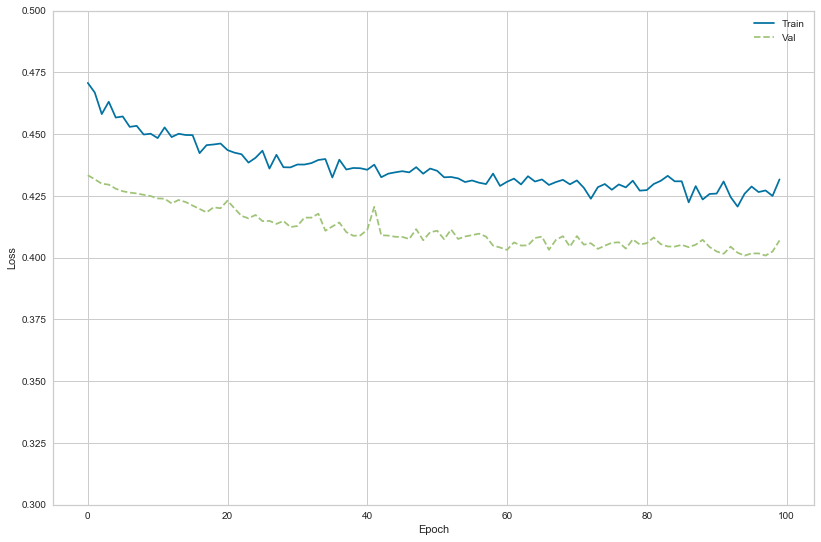

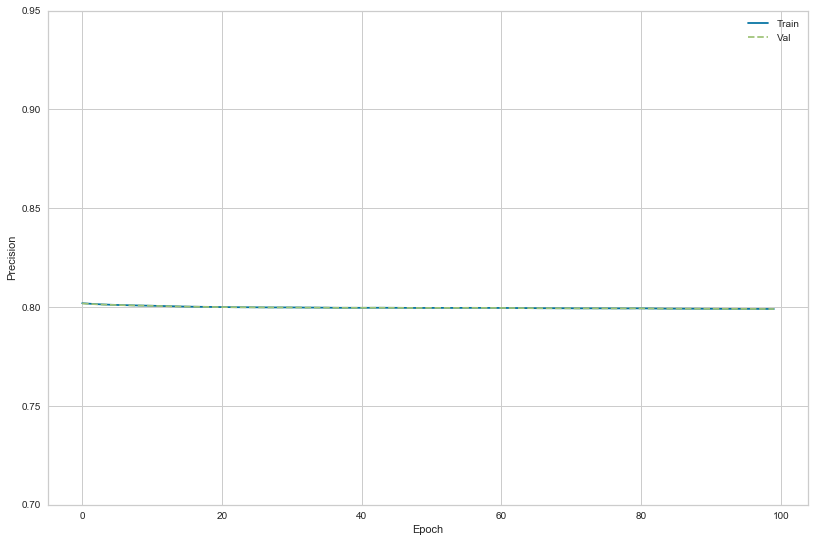

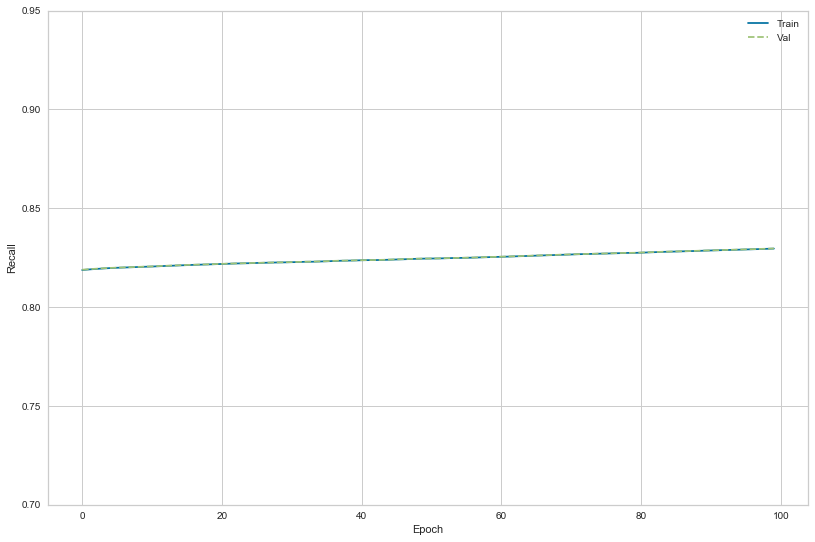

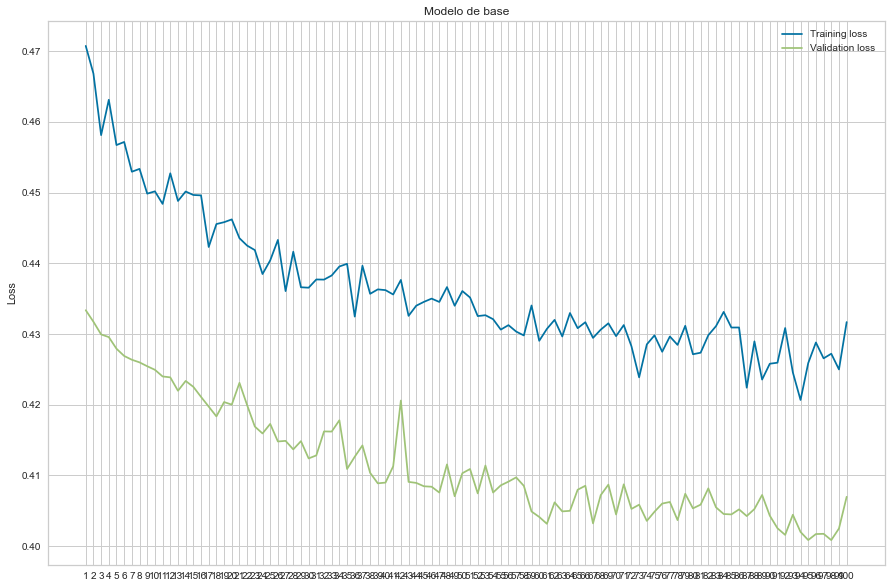

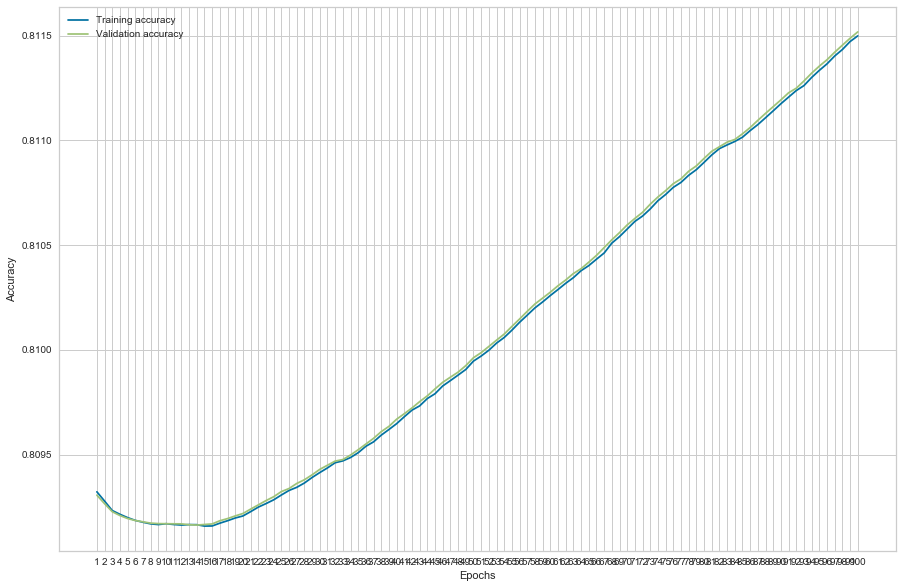

In [543]:
plot_metrics(history2)

<a id="ed14"></a>
### Resultados

In [544]:
print('\n# Evaluate on test data')
results = model1.evaluate(X_test, y_test, batch_size=128)
print('loss:',results[0])
print('TP:',results[1])
print('FP:',results[2])
print('TN:',results[3])
print('FN:',results[4])
print('accuracy:',results[5])
print('precision:',results[6])
print('recall:',results[7])


# Evaluate on test data
2070/2070 [==============================] - 0s 13us/step
loss: 0.431583755661324
TP: 2582241.75
FP: 649367.8125
TN: 2496028.25
FN: 529988.0
accuracy: 0.8115330934524536
precision: 0.7990574836730957
recall: 0.8297079801559448
